In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"apollopubg","key":"3c6e2519fa3fc29b6143e88f14a90408"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d aftabhussaincui/refined-rnsa-ct-scans-12k-pngs
! unzip refined-rnsa-ct-scans-12k-pngs.zip

Streaming output truncated to the last 5000 lines.
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b027f72f3.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b040c71e9.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b05572259.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b062eb6db.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b066d9f17.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b08d9e985.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b09303d23.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b1003930f.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b10ce000b.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b11a38066.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b11bfe8b8.png  
  inflating: RNSA_Subset_PNGs_12K/Intraventricular_Positive/ID_b11e58e30.png  
 

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout, SpatialDropout2D ,BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os, random, shutil
from random import uniform

In [6]:
learning_rate = 1e-4
batch_size = 32
epochs_number = 100

In [7]:
dataset_path = 'RNSA_Subset_PNGs_12K'

In [8]:
! rm 'RNSA_Subset_PNGs_12K/Meta data.txt'

In [9]:
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

# Initialize empty lists to store the file paths for each set
train_set, validation_set, test_set = [], [], []

# Loop over each folder and split the PNG images into sets
for folder in folders:
    # Get the folder name (label)
    folder_name = os.path.basename(folder)
    # Get a list of all the PNG images in the folder
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    # Define the percentage split for train, validation, and test sets
    train_percent, validation_percent, test_percent = 0.75, 0.15, 0.1
    # Split the PNG images into train, validation, and test sets
    num_files = len(png_images)
    train_end = int(num_files * train_percent)
    validation_end = int(num_files * (train_percent + validation_percent))
    train_set += png_images[:train_end]
    validation_set += png_images[train_end:validation_end]
    test_set += png_images[validation_end:]

In [10]:
for directory in ['Train', 'Validation', 'Test']:
    os.makedirs(os.path.join(dataset_path, directory), exist_ok=True)


# Loop over the train, validation, and test sets, and copy each image to the appropriate directory
for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in ['Normal', 'Epidural_Positive','Intraventricular_Positive', 'Subdural_Positive', 'Intraparenchymal_Positvie', 'Subarachnoid_Positive', 'Any_Positive']:
        # Create the folder in the set directory
        os.makedirs(os.path.join(dataset_path, set_name, folder_name), exist_ok=True)
        # Get the images in the current folder
        folder_files = [f for f in set_files if folder_name in f]
        # Copy the images to the set directory
        for f in folder_files:
            dest_folder = os.path.join(dataset_path, set_name, folder_name)
            shutil.copy(f, dest_folder)

# Print the number of images in each set
print("Train set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Train set size: 9000
Validation set size: 1800
Test set size: 1200


In [11]:
def initialize_model(name):
  model = tf.keras.models.Sequential(name=name)
      # Convolutional layer 1
  model.add(Conv2D(filters=96, kernel_size=(7, 7), strides=(2, 2), activation='relu', input_shape=(256, 256, 3)))
  model.add(SpatialDropout2D(0.3))
  model.add(BatchNormalization())
      # Convolutional layer 2
  model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
      # Convolutional layer 3
  model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
  model.add(SpatialDropout2D(0.3))
  # model.add(BatchNormalization())
      # Convolutional layer 4
  model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
  model.add(SpatialDropout2D(0.4))
      # Convolutional layer 5
  model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
  # model.add(SpatialDropout2D(0.2))
  model.add( MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
  # model.add(SpatialDropout2D(0.2))
      # Flatten the output from convolutional layers
  model.add(Flatten())
  # model.add(Dropout(uniform(0, 1)))
      # Fully-connected layer 1
  model.add(Dense(units=4026, activation='relu'))
  model.add(Dropout(uniform(0, 1)))
      # Fully-connected layer 2
  model.add(Dense(units=4026, activation='relu'))
  model.add(Dropout(uniform(0, 1)))
  model.add (Dense(units=7, activation='softmax'))
  return model

In [12]:
model = initialize_model(name="ZFnet")
model.summary()

Model: "ZFnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 96)      14208     
                                                                 
 spatial_dropout2d (SpatialD  (None, 125, 125, 96)     0         
 ropout2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 96)     384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 256)      0         
 )                                                               
                                                             

In [13]:

def compile_model(model):
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
train_data = train_datagen.flow_from_directory('RNSA_Subset_PNGs_12K/Train', 
                                               target_size = (256, 256), 
                                               batch_size = batch_size, 
                                               class_mode = 'categorical')
validation_data = train_datagen.flow_from_directory('RNSA_Subset_PNGs_12K/Validation', 
                                                    target_size = (256, 256), 
                                                    batch_size = batch_size, 
                                                    class_mode = 'categorical')

Found 6006 images belonging to 7 classes.
Found 1596 images belonging to 7 classes.


In [16]:
model = compile_model(model)
res_history = model.fit(train_data, 
                        validation_data = validation_data, 
                        epochs = 100, 
                        steps_per_epoch = len(train_data), 
                        validation_steps = len(validation_data))

Epoch 1/100
188/188 [==============================] - 71s 290ms/step - loss: 2.2583 - accuracy: 0.2070 - val_loss: 1.9180 - val_accuracy: 0.4361
Epoch 2/100
188/188 [==============================] - 55s 291ms/step - loss: 1.9148 - accuracy: 0.2474 - val_loss: 1.8880 - val_accuracy: 0.4361
Epoch 3/100
188/188 [==============================] - 54s 287ms/step - loss: 1.9047 - accuracy: 0.2481 - val_loss: 1.8334 - val_accuracy: 0.4361
Epoch 4/100
188/188 [==============================] - 55s 293ms/step - loss: 1.8932 - accuracy: 0.2517 - val_loss: 1.7526 - val_accuracy: 0.4361
Epoch 5/100
188/188 [==============================] - 54s 286ms/step - loss: 1.8836 - accuracy: 0.2496 - val_loss: 1.7652 - val_accuracy: 0.4361
Epoch 6/100
188/188 [==============================] - 54s 286ms/step - loss: 1.8794 - accuracy: 0.2481 - val_loss: 1.8392 - val_accuracy: 0.4361
Epoch 7/100
188/188 [==============================] - 54s 287ms/step - loss: 1.8627 - accuracy: 0.2473 - val_loss: 1.7935 -

In [17]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

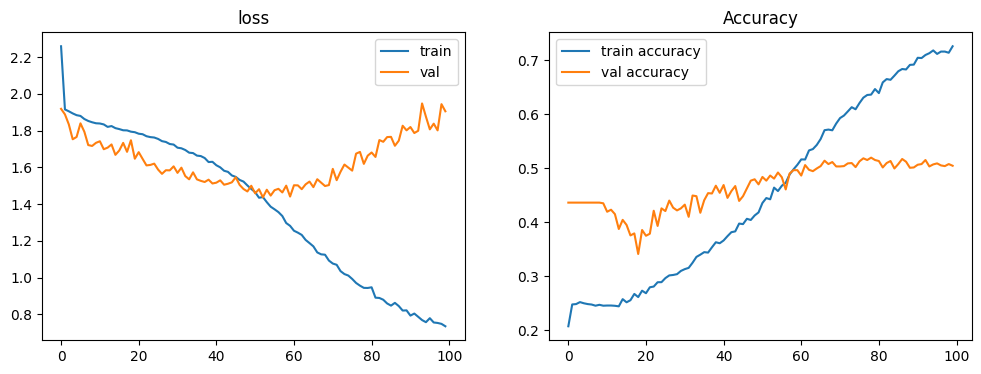

In [18]:
plot_history(res_history, title='', axs=None, exp_name="");

In [34]:
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])
    # Label array
    labels = {0: 'Any', 1: 'Epidural', 2: 'Intraparenchymal', 3: 'Intraventricular', 4: 'normal', 5: 'Subarachnoid',
              6: 'Subdural'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("pred:", predicted_class)
    print("correct :"+str(img_rel_path).split("/")[1], "\n\n")
    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()

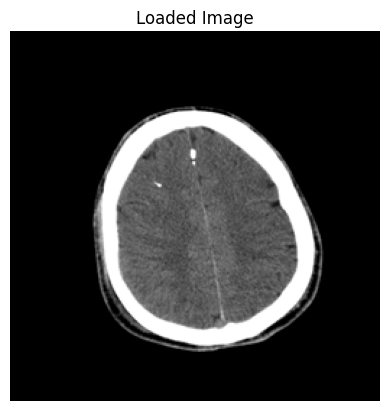

1/1 [==============================] - 0s 21ms/step


Maximum Probability:  0.745747
pred: normal
correct :Subdural_Normal 



-------------------Individual Probability--------------------------------

ANY : 5.74 %
EPIDURAL : 1.23 %
INTRAPARENCHYMAL : 2.12 %
INTRAVENTRICULAR : 0.28 %
NORMAL : 74.57 %
SUBARACHNOID : 7.39 %
SUBDURAL : 8.67 %


In [35]:
predict(test_set[10])

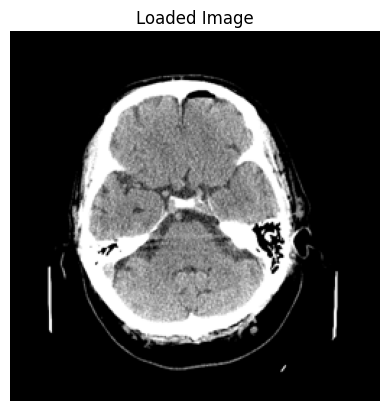

1/1 [==============================] - 0s 91ms/step


Maximum Probability:  0.99999964
pred: normal
correct :Subarachnoid_Normal 



-------------------Individual Probability--------------------------------

ANY : 0.0 %
EPIDURAL : 0.0 %
INTRAPARENCHYMAL : 0.0 %
INTRAVENTRICULAR : 0.0 %
NORMAL : 100.0 %
SUBARACHNOID : 0.0 %
SUBDURAL : 0.0 %


In [43]:
predict(test_set[145])

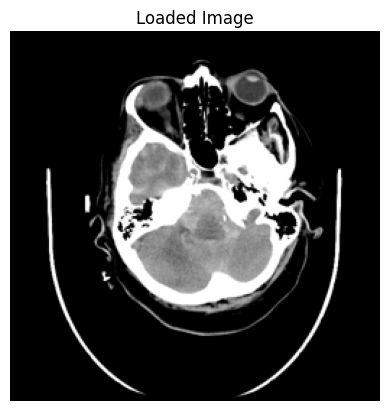

1/1 [==============================] - 0s 20ms/step


Maximum Probability:  0.9866832
pred: Subarachnoid
correct :Subarachnoid_Positive 



-------------------Individual Probability--------------------------------

ANY : 0.6 %
EPIDURAL : 0.02 %
INTRAPARENCHYMAL : 0.16 %
INTRAVENTRICULAR : 0.11 %
NORMAL : 0.17 %
SUBARACHNOID : 98.67 %
SUBDURAL : 0.27 %


In [47]:
predict(train_set[3815])

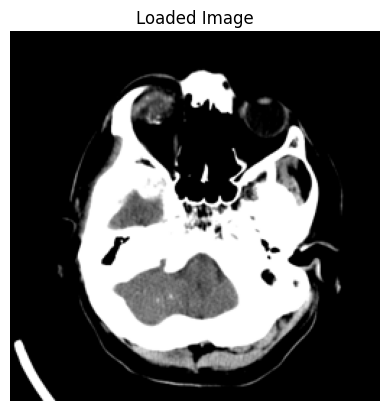

1/1 [==============================] - 0s 33ms/step


Maximum Probability:  0.9995024
pred: normal
correct :Intraparenchymal_Normal 



-------------------Individual Probability--------------------------------

ANY : 0.04 %
EPIDURAL : 0.0 %
INTRAPARENCHYMAL : 0.0 %
INTRAVENTRICULAR : 0.0 %
NORMAL : 99.95 %
SUBARACHNOID : 0.0 %
SUBDURAL : 0.0 %


In [50]:
predict(train_set[6725])

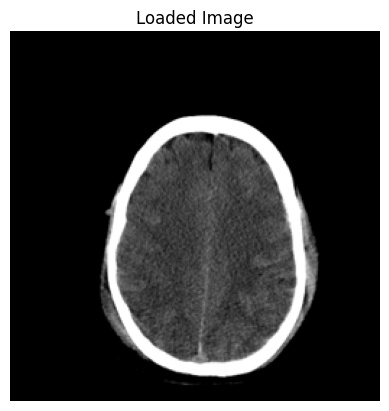

1/1 [==============================] - 0s 40ms/step


Maximum Probability:  0.31746238
pred: Subarachnoid
correct :Subarachnoid_Positive 



-------------------Individual Probability--------------------------------

ANY : 12.9 %
EPIDURAL : 6.86 %
INTRAPARENCHYMAL : 10.77 %
INTRAVENTRICULAR : 2.92 %
NORMAL : 3.96 %
SUBARACHNOID : 31.75 %
SUBDURAL : 30.84 %


In [52]:
predict(test_set[515])

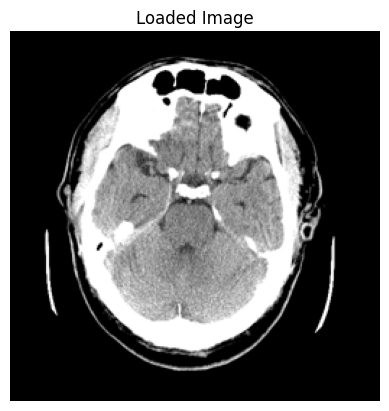

1/1 [==============================] - 0s 27ms/step


Maximum Probability:  0.9993678
pred: normal
correct :Any_Normal 



-------------------Individual Probability--------------------------------

ANY : 0.04 %
EPIDURAL : 0.0 %
INTRAPARENCHYMAL : 0.01 %
INTRAVENTRICULAR : 0.0 %
NORMAL : 99.94 %
SUBARACHNOID : 0.01 %
SUBDURAL : 0.01 %


In [53]:
predict(test_set[255])